# Spatial analysis of Xenium Dataset

In [1]:
# <a href="https://colab.research.google.com/github/pachterlab/voyagerpy/blob/main/examples/xenium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [2]:
import sys
import subprocess

def install_packages_colab():
    """Install Python packages using pip."""
    packages = [
        'voyagerpy==0.1.1',
        'gget==0.28.4',
        'watermark==2.4.3',
        'scanpy==1.10.1'
    ]
    # Command construction for pip install
    command = [sys.executable, '-m', 'pip', 'install'] + packages
    try:
        # Execute the command
        subprocess.check_call(command)
        print("Packages installed successfully.")
    except subprocess.CalledProcessError:
        print("Failed to install packages.")
        raise

if 'google.colab' in sys.modules:  # if in google colab
    install_packages_colab()

In [3]:
import voyagerpy as vp

# File management and downloading
import os
import pathlib

# Data handling and plotting
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import LogLocator, NullFormatter
from matplotlib.cm import ScalarMappable
import matplotlib.patches as patches
from shapely.geometry import Polygon, MultiPolygon, box
import scipy.sparse as sp


plt.rcParams['axes.grid'] = False
plt.rcParams['axes.edgecolor'] = 'none'  # Hides the axes border
# plt.rcParams['xtick.color'] = 'none'  # Hides x-axis ticks
# plt.rcParams['ytick.color'] = 'none'  # Hides y-axis ticks

plt.rcParams['figure.dpi'] = 120

# Turn on matplotlib interactive mode so we don't need to explicitly call plt.show()
_ = plt.ion()

Download the dataset

In [4]:
root_dir = pathlib.Path(os.getcwd())
outs_dir = pathlib.Path(f'{root_dir}/outs/xenium')

outs_dir.mkdir(parents=True, exist_ok=True)

In [5]:
# Download the unfiltered gene count matrix
box_link = "https://caltech.box.com/shared/static/m8g4ltvwqm2ych7b3ua9ibx94ozacttc.gz"

tar_path = outs_dir / 'xenium2_pancreas.tar.gz'
url_reads = box_link
vp.utils.download_data(tar_path, url_reads)

Load in the data

In [6]:
data_folder = f"{outs_dir}/xenium2_pancreas"
adata = vp.read_xenium(data_folder)

matrix
matrix/barcodes
matrix/data
matrix/features
matrix/features/_all_tag_keys
matrix/features/feature_type
matrix/features/genome
matrix/features/id
matrix/features/name
matrix/indices
matrix/indptr
matrix/shape


In [7]:
print(adata)
# adata.obs.head()
# adata.var.head()
# adata.obsm['geometry'].head()

AnnData object with n_obs × n_vars = 140702 × 541
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'feature_type'
    uns: 'transcripts', 'technology'
    obsm: 'geometry'


Correct invalid polygons

In [8]:
def correct_invalid_polygons(row):
    if row['cellSeg'] and not row['cellSeg'].is_valid:
        row['cellSeg'] = row['cellSeg'].buffer(0)

    if row['nucSeg'] and not row['nucSeg'].is_valid:
        row['nucSeg'] = row['nucSeg'].buffer(0)

    return row

adata.obsm['geometry'] = adata.obsm['geometry'].apply(correct_invalid_polygons, axis=1)

Print the different types of genes in adata.var - everything besides 'Gene Expression' is a negative control

In [9]:
adata.var.feature_type.unique()

array(['Gene Expression', 'Negative Control Probe',
       'Negative Control Codeword', 'Unassigned Codeword'], dtype=object)

Plot 2D histograms of cell centroids to understand the spatial distribution of cells

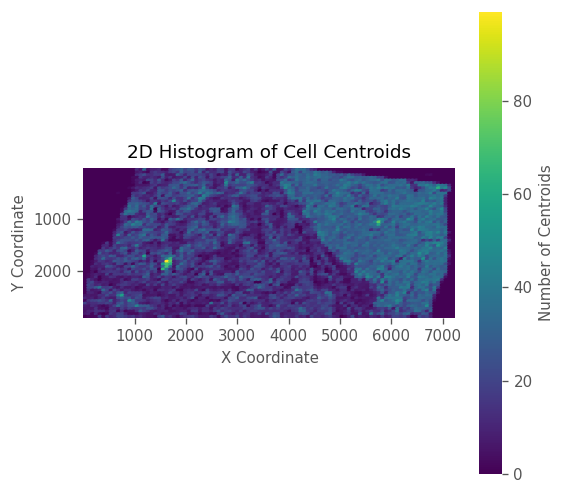

In [10]:
vp.plotting.plot_2d_histogram(adata.obs['x_centroid'], adata.obs['y_centroid'], bin_shape='hex')

Plot cell and nucleus segmentation geometries

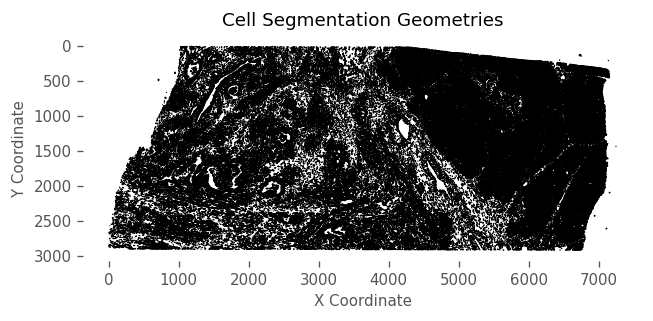

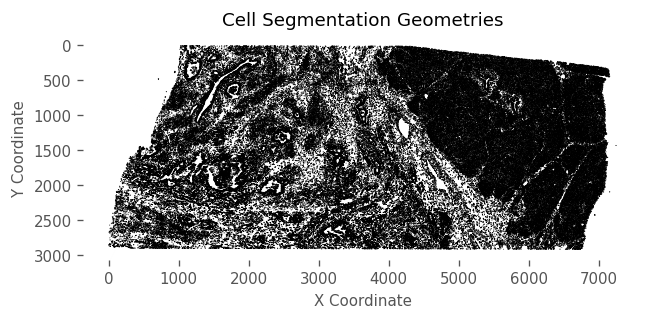

/root/venv_list/voyagerpy_env/lib/python3.9/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


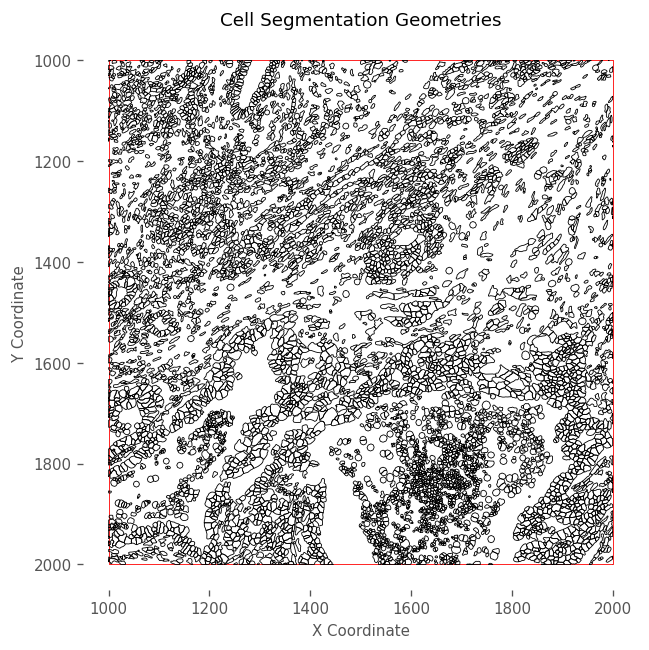

In [11]:
vp.plotting.plot_segmentation_geometries(adata.obsm['geometry']['cellSeg'])
vp.plotting.plot_segmentation_geometries(adata.obsm['geometry']['nucSeg'])
vp.plotting.plot_segmentation_geometries(adata.obsm['geometry']['cellSeg'], bbox = (1000, 1000, 2000, 2000))  # (minx, miny, maxx, maxy)

Calculate fractions of transcript and non_transcript counts

In [12]:
adata.obs['fraction_transcript_counts'] = adata.obs['transcript_counts'] / adata.obs['total_counts']
adata.obs['fraction_nontranscript_counts'] = 1 - adata.obs['fraction_transcript_counts']

Load in an image and display it

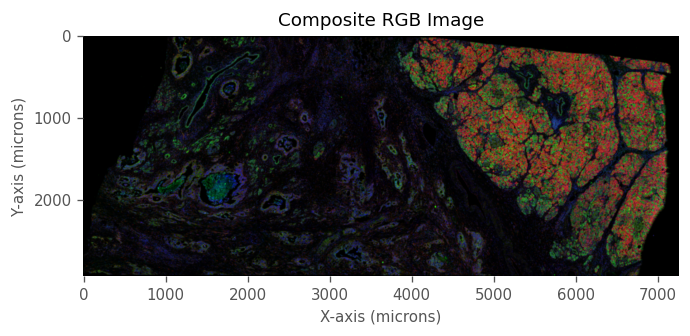

In [13]:
file_path_dapi = f'{data_folder}/morphology_focus/morphology_focus_0000.ome.tif'
file_path_cadherin = f'{data_folder}/morphology_focus/morphology_focus_0001.ome.tif'
file_path_rib18s = f'{data_folder}/morphology_focus/morphology_focus_0002.ome.tif'
uncropped_image_level = 5

image_uncropped = vp.utils.load_3d_image(red_path = file_path_rib18s, green_path = file_path_cadherin, blue_path = file_path_dapi, level = uncropped_image_level, axis_units = "microns", normalize = True)

if "spatial" not in adata.uns:
    adata.uns["spatial"] = {}
if "img" not in adata.uns["spatial"]:
    adata.uns["spatial"]["img"] = {}

adata.uns["spatial"]["img"][str(uncropped_image_level)] = image_uncropped

vp.plotting.plot_xenium_image(adata, adata.uns["spatial"]["img"][str(uncropped_image_level)], ticks = "microns", image_file_path = file_path_dapi, image_level = uncropped_image_level)

Draw bounding boxes on the image

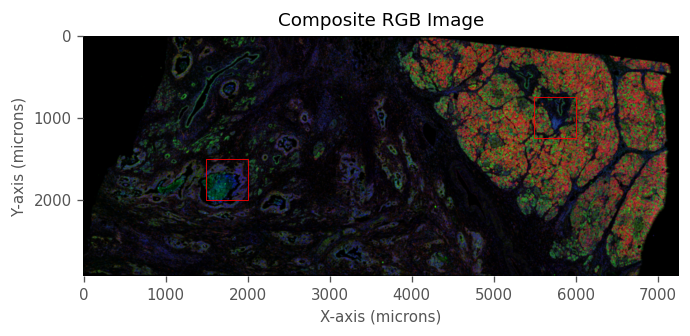

In [14]:
bbox1 = (5500, 750, 6000, 1250)  # (x_min, y_min, x_max, y_max)
bbox2 = (1500, 1500, 2000, 2000)

bboxes = [bbox1, bbox2]
vp.plotting.plot_xenium_image(adata, image_uncropped, ticks = "microns", image_file_path = file_path_dapi, image_level = uncropped_image_level, bboxes = bboxes)

Find an appropriate image resolution given the maximum number of pixels, and zoom into a bounding box

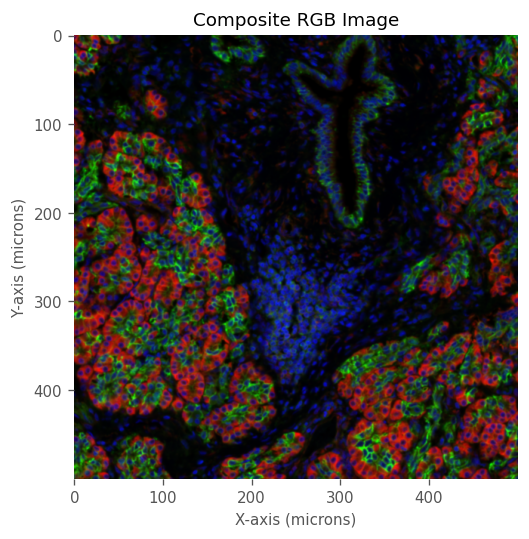

In [15]:
max_pixels = 500000
cropped_image_level1 = vp.utils.find_appropriate_image_resolution(file_path_dapi, max_pixels=max_pixels, bbox=bbox1, axis_units="microns")
image_cropped1 = vp.utils.load_3d_image(red_path = file_path_rib18s, green_path = file_path_cadherin, blue_path = file_path_dapi, level = cropped_image_level1, bbox = bbox1, axis_units = "microns", normalize = True)

vp.plotting.plot_xenium_image(adata, image_cropped1, ticks = "microns", image_file_path = file_path_dapi, image_level = cropped_image_level1, spacing_microns = 100)

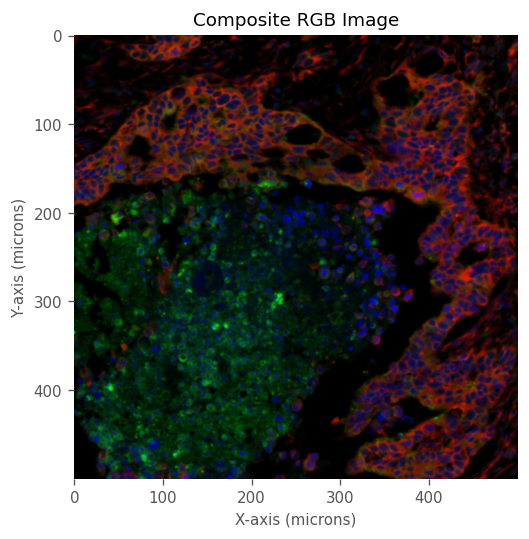

In [16]:
cropped_image_level2 = vp.utils.find_appropriate_image_resolution(file_path_dapi, max_pixels=max_pixels, bbox=bbox2, axis_units="microns")
image_cropped2 = vp.utils.load_3d_image(red_path = file_path_rib18s, green_path = file_path_cadherin, blue_path = file_path_dapi, level = cropped_image_level2, bbox = bbox2, axis_units = "microns", normalize = True)

vp.plotting.plot_xenium_image(adata, image_cropped2, ticks = "microns", image_file_path = file_path_dapi, image_level = cropped_image_level2, spacing_microns = 100)

Plot each color channel separately

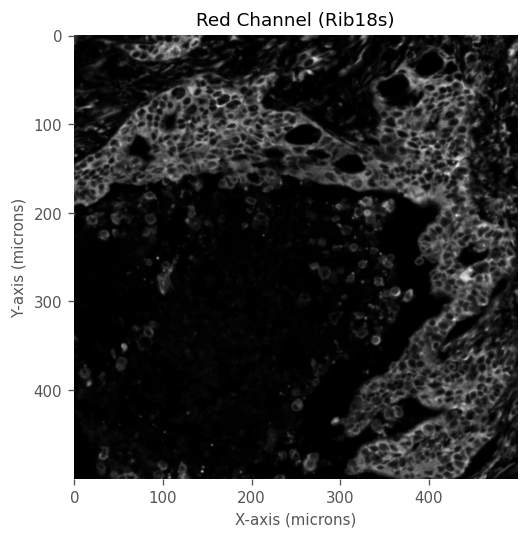

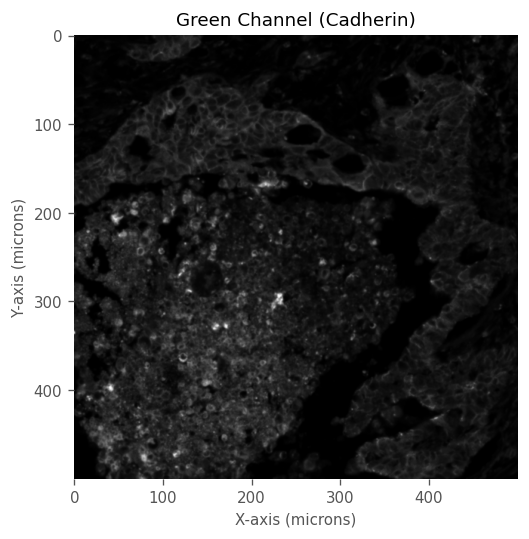

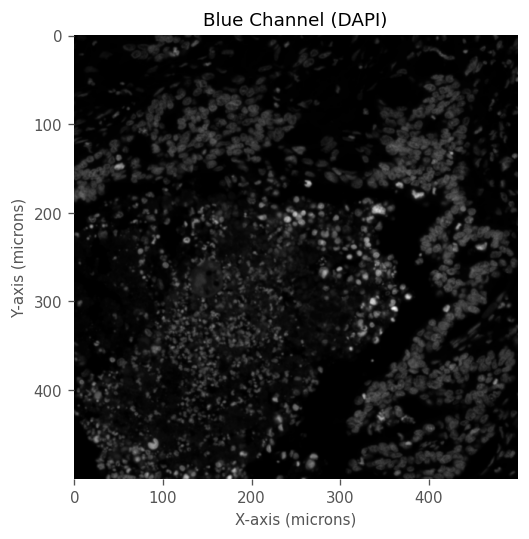

In [17]:
red_channel = image_cropped2[:, :, 0]
green_channel = image_cropped2[:, :, 1]
blue_channel = image_cropped2[:, :, 2]

vp.plotting.plot_xenium_image(adata, red_channel, ticks = "microns", image_file_path = file_path_dapi, image_level = cropped_image_level2, spacing_microns = 100, global_cmap = 'gray', title = "Red Channel (Rib18s)")
vp.plotting.plot_xenium_image(adata, green_channel, ticks = "microns", image_file_path = file_path_dapi, image_level = cropped_image_level2, spacing_microns = 100, global_cmap = 'gray', title = "Green Channel (Cadherin)")
vp.plotting.plot_xenium_image(adata, blue_channel, ticks = "microns", image_file_path = file_path_dapi, image_level = cropped_image_level2, spacing_microns = 100, global_cmap = 'gray', title = "Blue Channel (DAPI)")

Plot cell segmentations on top of the image

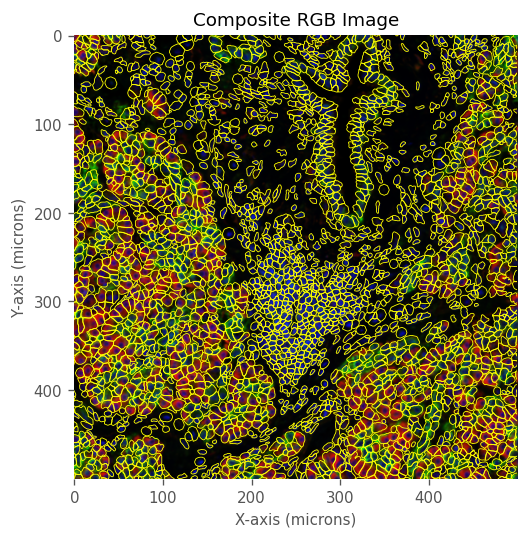

In [18]:
vp.plotting.plot_xenium_image(adata, image_cropped1, ticks = "microns", image_file_path = file_path_dapi, image_level = cropped_image_level1, spacing_microns = 100, bboxes = [bbox1], geometries = adata.obsm['geometry']['cellSeg'])

Handle missing nuclei with 0s

In [19]:
if adata.obsm['geometry']['nucSeg'].isnull().any():
    adata.obsm['geometry']['nucSeg'] = adata.obsm['geometry']['nucSeg'].apply(lambda geom: Polygon() if geom is None or pd.isnull(geom) else geom)
    adata.obs['nucleus_area'].fillna(0, inplace=True)

/tmp/ipykernel_35356/2075397394.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['nucleus_area'].fillna(0, inplace=True)


Plot nucleus segmentations

/root/venv_list/voyagerpy_env/lib/python3.9/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


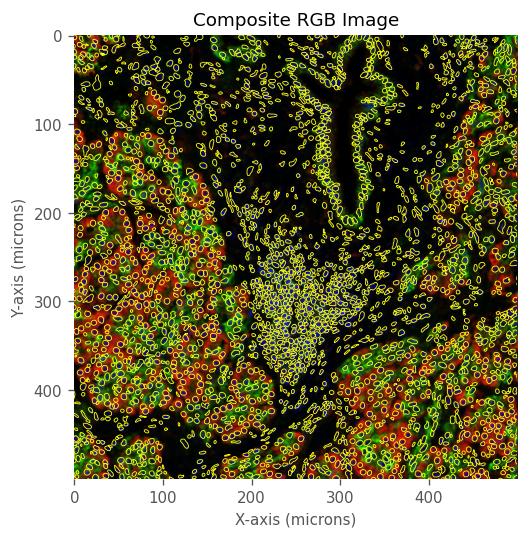

In [20]:
vp.plotting.plot_xenium_image(adata, image_cropped1, ticks = "microns", image_file_path = file_path_dapi, image_level = cropped_image_level1, spacing_microns = 100, bboxes = [bbox1], geometries = adata.obsm['geometry']['nucSeg'])

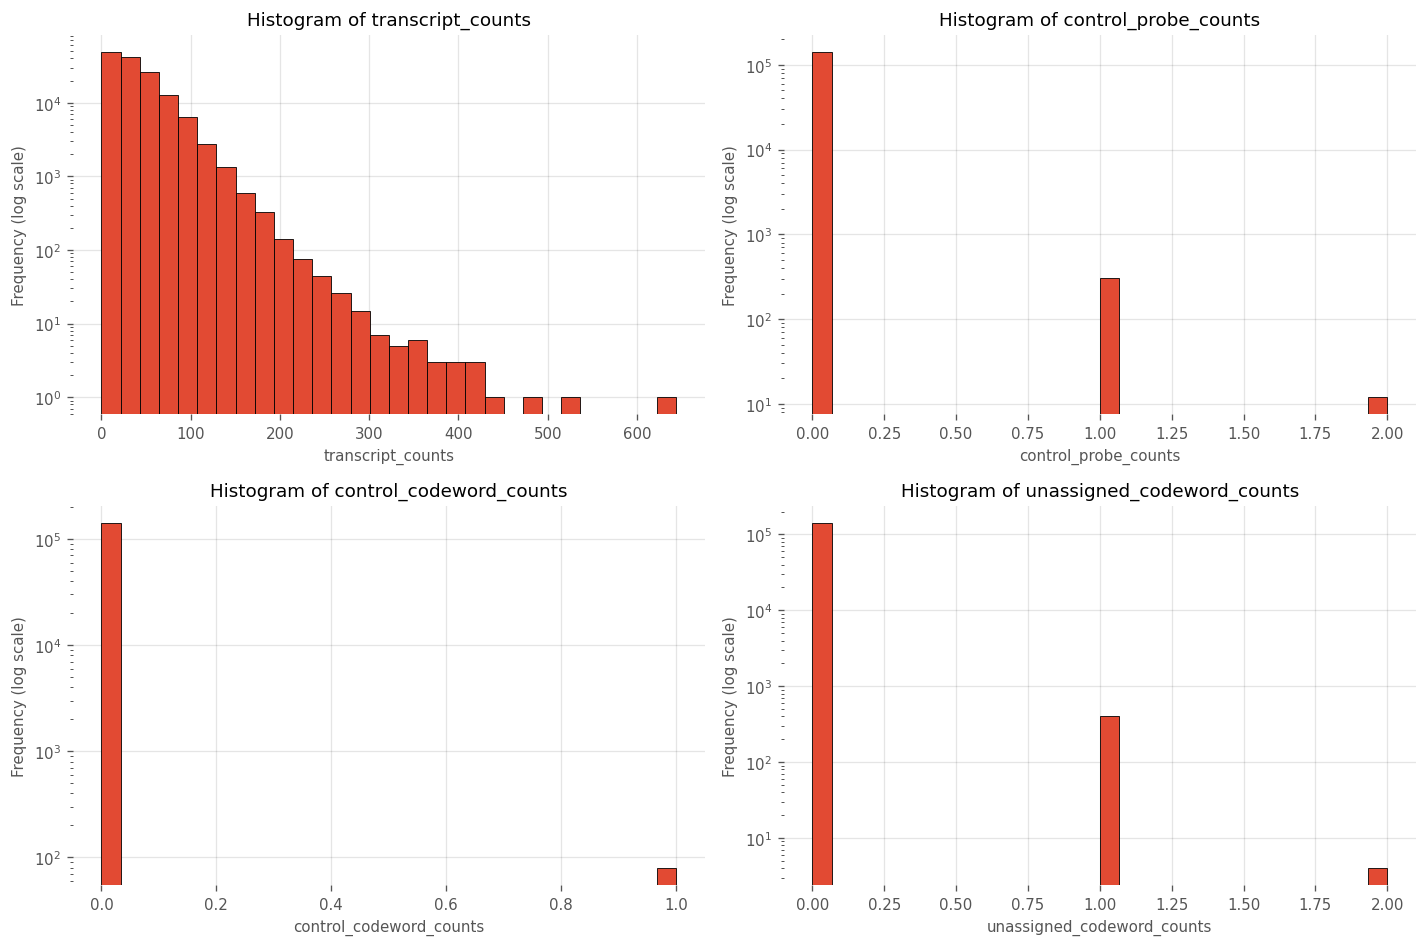

In [21]:
count_names = ["transcript_counts", "control_probe_counts", "control_codeword_counts", "unassigned_codeword_counts"]
vp.plotting.make_histograms(adata, count_names)

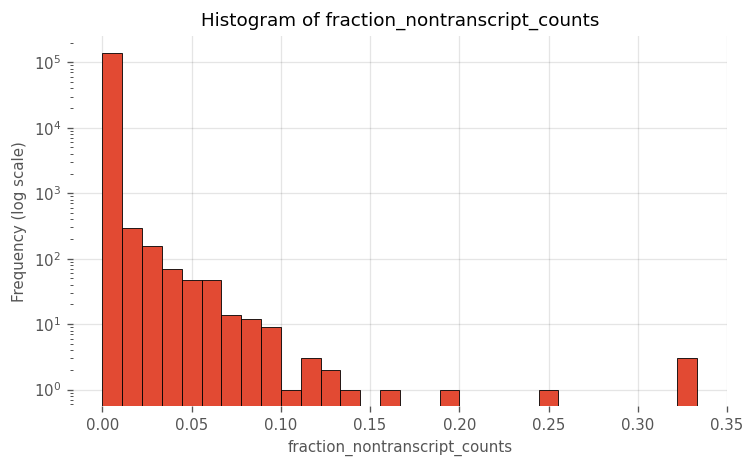

In [22]:
vp.plotting.make_histograms(adata, ["fraction_nontranscript_counts"])

### Because the vast majority of cells have 0 non-transcript counts, this indicates high quality data

In [23]:
adata.uns['transcripts'].loc[adata.uns['transcripts']['feature_name'].str.contains('Unassigned', na=False) | adata.uns['transcripts']['feature_name'].str.contains('NegControl', na=False)]

transcript_id     cell_id  overlaps_nucleus  \
85       281608120711779  UNASSIGNED                 0   
568      281608120700373  fdhdfglj-1                 1   
840      281608120708109  UNASSIGNED                 0   
847      281608120708997  fdhdfnfb-1                 1   
1043     281608120713091  UNASSIGNED                 0   
...                  ...         ...               ...   
8070026  281603825926790  bimpgnmi-1                 0   
8071176  281603825955270  bipjoflm-1                 1   
8071183  281603825955299  bipjjlof-1                 1   
8071663  281603825966673  biggnagb-1                 0   
8073656  281655365401891  UNASSIGNED                 0   

                    feature_name   x_location   y_location  z_location  \
85       UnassignedCodeword_0427    25.750742  1664.851562   13.665799   
568      UnassignedCodeword_0422   209.897507  1889.549927   22.032629   
840      UnassignedCodeword_0407   244.294922  1849.346680   17.047949   
847      UnassignedCodeword_0425   211.839294  1891.210327   20.465139   
1043     NegControlCodeword_0534   249.196548  1942.801147   15.634063   
...                          ...          ...          ...         ...   
8070026  NegControlCodeword_0534  7006.359863  2094.849121   18.511732   
8071176  NegControlCodeword_0537  7002.928223  2024.422485   15.550384   
8071183  NegControlCodeword_0528  7015.385254  2028.441772   16.517199   
8071663  NegControlCodeword_0531  7068.588379  2001.761353   16.007790   
8073656    NegControlProbe_00033  7165.945312  2490.465332   13.279260   

                qv fov_name  nucleus_distance  codeword_index  
85       11.950697       Q7        236.691910             427  
568      12.955800       Q7          0.000000             422  
840       6.828043       Q7          3.712178             407  
847       6.237434       Q7          0.000000             425  
1043     14.144480       Q7          3.256386             534  
...            ...      ...               ...             ...  
8070026  14.327777      Q18          0.236572             534  
8071176   7.089683      Q18          0.000000             537  
8071183   7.852499      Q18          0.000000             528  
8071663   6.659402      Q18          1.430925             531  
8073656   7.953732      R18        226.388763               5  

[27251 rows x 11 columns]

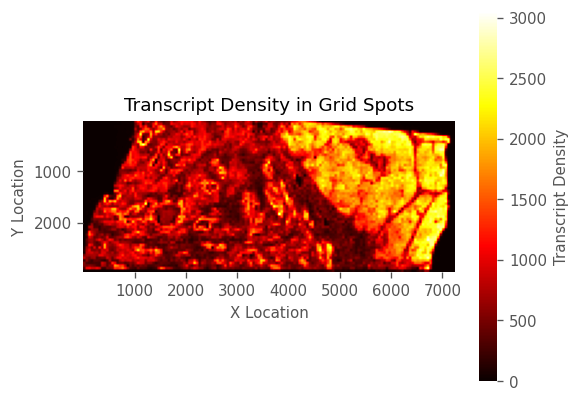

/workspace/voyagerpy/plotting/plot.py:3628: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df['x_bin'] = np.digitize(transcripts_df['x_location'], x_bins) - 1
/workspace/voyagerpy/plotting/plot.py:3629: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_df['y_bin'] = np.digitize(transcripts_df['y_location'], y_bins) - 1


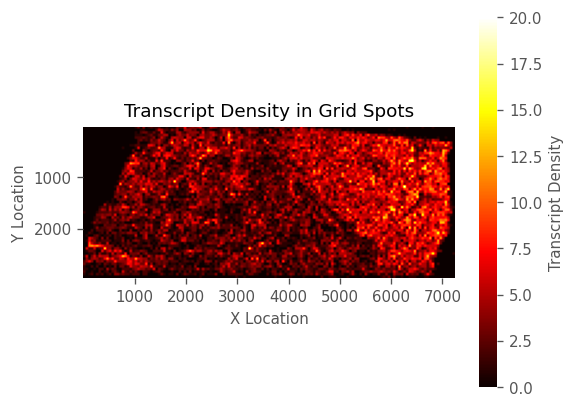

In [24]:
vp.plotting.plot_transcripts(adata.uns['transcripts'])
vp.plotting.plot_transcripts(adata.uns['transcripts'], negative_control = True)

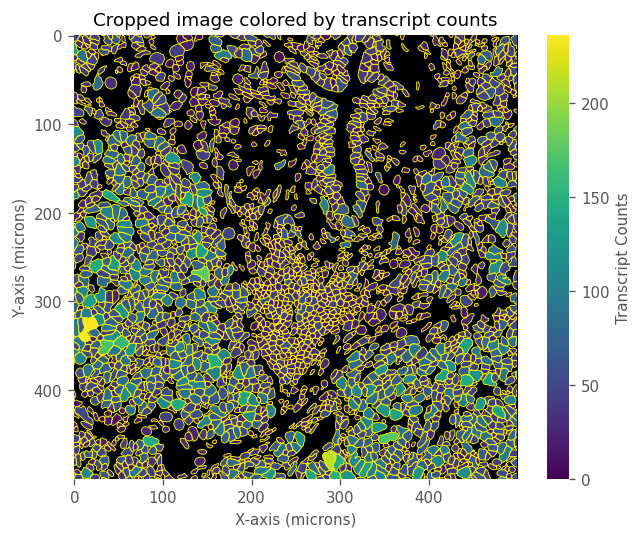

In [25]:
vp.plotting.plot_xenium_image(adata, image_cropped1, ticks = "microns", image_file_path = file_path_dapi, image_level = cropped_image_level1, spacing_microns = 100, bboxes = [bbox1], geometries = adata.obsm['geometry']['cellSeg'], color_polygons = "transcript_counts", title = "Cropped image colored by transcript counts")

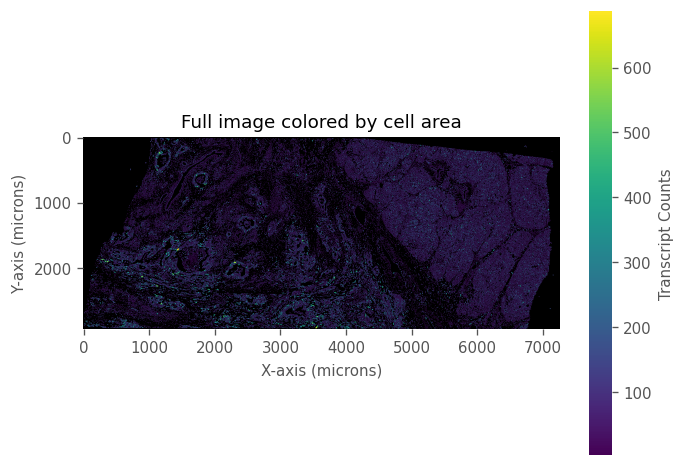

In [26]:
vp.plotting.plot_xenium_image(adata, image_uncropped, ticks = "microns", image_file_path = file_path_dapi, image_level = uncropped_image_level, spacing_microns = 1000, geometries = adata.obsm['geometry']['cellSeg'], color_polygons = "cell_area", title = "Full image colored by cell area")

In [27]:
adata = vp.utils.run_knn(adata, adata_obs_x_name = 'x_centroid', adata_obs_y_name = 'y_centroid', n_neighbors = 5, weight_matrix_method = 'binary')

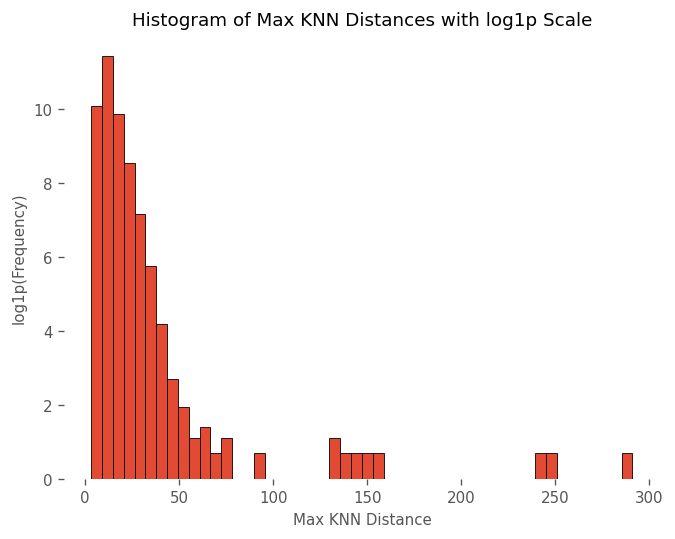

In [28]:
# Plot a histogram of the max distances
counts, bins = np.histogram(adata.obs['knn_distance_max'], bins=50)

log_counts = np.log1p(counts)

plt.bar(bins[:-1], log_counts, width=np.diff(bins), edgecolor='black', align='edge')
plt.xlabel('Max KNN Distance')
plt.ylabel('log1p(Frequency)')
plt.title('Histogram of Max KNN Distances with log1p Scale')
plt.show()

Identify islands by max KNN distance

In [29]:
max_knn_distance = 60
adata.obs['is_island'] = adata.obs['knn_distance_max'] > max_knn_distance

In [30]:
island_centroids = adata.obs.loc[adata.obs['is_island'], ['x_centroid', 'y_centroid']]

island_centroid_tuples = list(island_centroids.itertuples(index=False, name=None))

Visualize islands

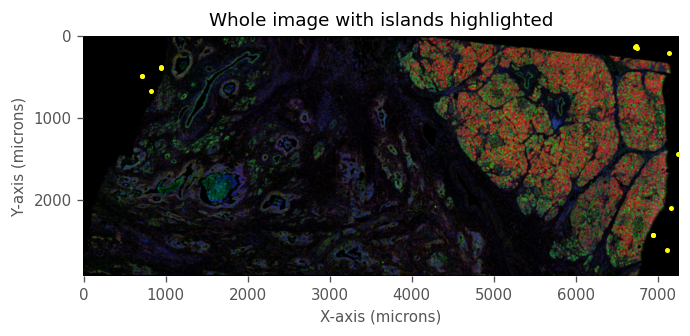

In [31]:
vp.plotting.plot_xenium_image(adata, image_uncropped, ticks = "microns", image_file_path = file_path_dapi, image_level = uncropped_image_level, spacing_microns = 1000, geometries = adata.obsm['geometry']['cellSeg'], global_cmap = "gray", title = "Whole image with islands highlighted", highlighted_points = island_centroid_tuples)

QC filtering - remove islands, cells with small transcript counts (5 here), genes with small transcript counts (0 here)

In [32]:
adata = adata[adata.obs['is_island'] == False, :]

minimum_counts_per_cell = 5
adata = adata[adata.obs['transcript_counts'] > minimum_counts_per_cell, :]

minimum_transcripts_per_gene = 0
gene_sums = np.sum(adata.X, axis=0)
adata.var['total_expression'] = gene_sums.tolist()[0]
adata = adata[:, adata.var['total_expression'] != 0]

/tmp/ipykernel_35356/678934892.py:8: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['total_expression'] = gene_sums.tolist()[0]


Rerun knn now that we have removed some cells

In [33]:
adata = vp.utils.run_knn(adata, adata_obs_x_name = 'x_centroid', adata_obs_y_name = 'y_centroid', n_neighbors = 5, weight_matrix_method = "binary")

/workspace/voyagerpy/utils/utils.py:707: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['knn_distances'] = distances_list


Add extra info to adata.var

In [34]:
adata.var['mean'] = np.mean(adata.X.toarray(), axis=0)
adata.var['variance'] = np.var(adata.X.toarray(), axis=0)

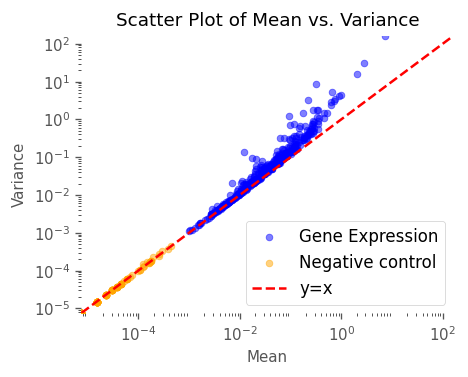

In [35]:
vp.plotting.mean_vs_variance_plot(adata)

In [36]:
#!!! if wanting to bypass memory issues
# adata = adata[:1000, :]
# adata = vp.utils.run_knn(adata, adata_obs_x_name = 'x_centroid', adata_obs_y_name = 'y_centroid', n_neighbors = 5, weight_matrix_method = "binary")

#!!! just for testing memory issues - erase later
# adata.obs['knn_distances'] = np.array(adata.obs['knn_distances'].tolist())
# adata.obs['knn_indices'] = np.array(adata.obs['knn_indices'].tolist())
# del adata.obsm['geometry']['cellSeg']
# del adata.obsm['geometry']['nucSeg']
# adata.write("/workspace/examples/outs/xenium/adata.h5ad")
# import anndata as ad
# import voyagerpy as vp
# adata = ad.read_h5ad("/workspace/examples/outs/xenium/adata.h5ad")

In [37]:
qc_features = ['transcript_counts', 'cell_area', 'nucleus_area']
vp.spatial.moran(adata, feature = qc_features, graph_name = 'knn_graph', permutations = 10)
adata.uns['spatial']['moran']['knn_graph'].loc[qc_features, ["I"]]

WOAHHH


/root/venv_list/voyagerpy_env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/root/venv_list/voyagerpy_env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/root/venv_list/voyagerpy_env/lib/python3.9/sit

1
2


/root/venv_list/voyagerpy_env/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


3
4
5


I
transcript_counts  0.265738
cell_area          0.189129
nucleus_area       0.220790

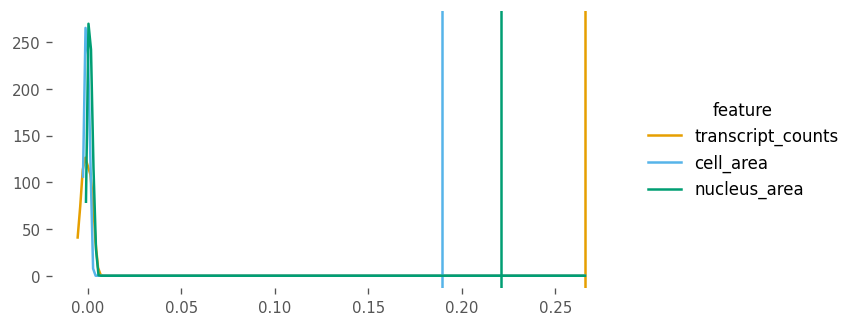

In [38]:
_ = vp.plotting.plot_moran_mc(adata, qc_features, 'knn_graph', figsize=(6,3))

In [39]:
_ = vp.spatial.local_moran(adata, feature = qc_features, graph_name = "knn_graph")

/root/venv_list/voyagerpy_env/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)
/root/venv_list/voyagerpy_env/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)
/root/venv_list/voyagerpy_env/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)


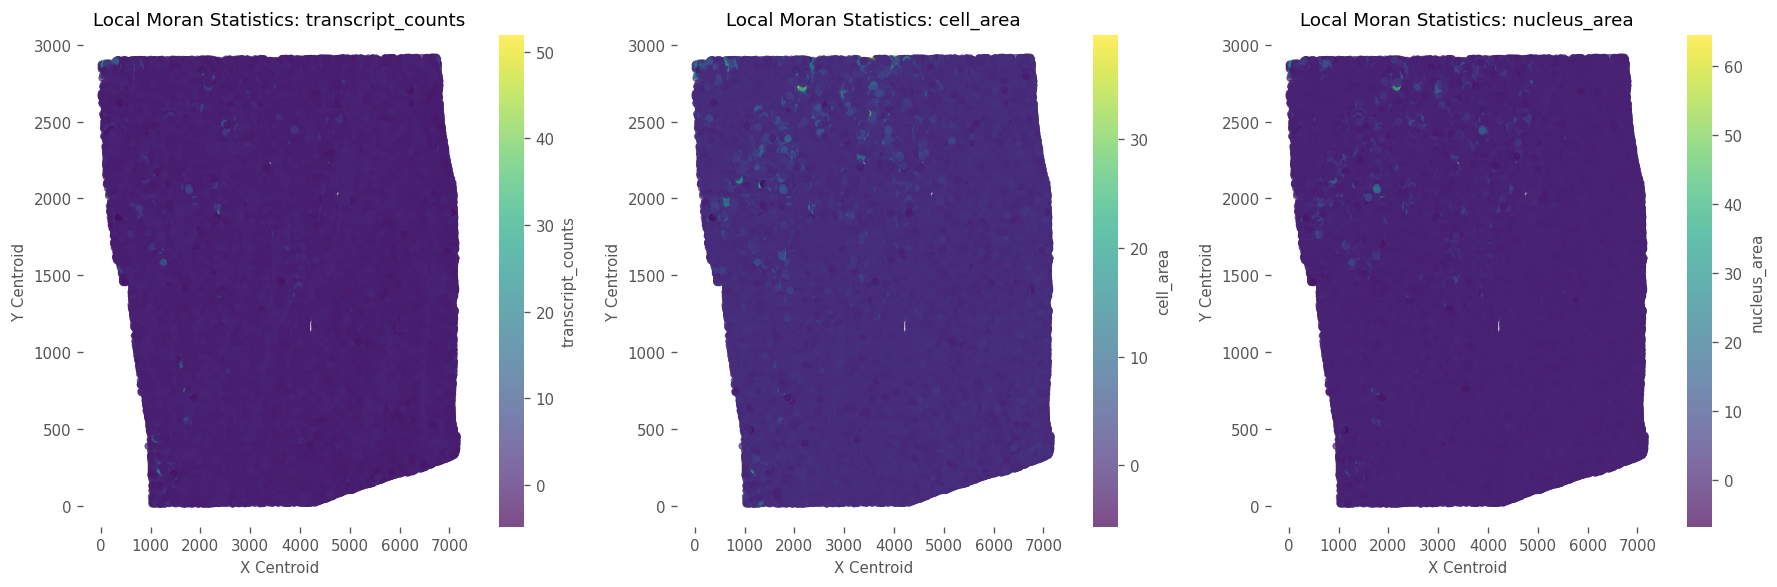

In [40]:
_ = vp.plotting.plot_local_result(adata, 'local_moran', qc_features)

array([[<AxesSubplot: xlabel='transcript_counts', ylabel='Spatially lagged transcript_counts'>]],
      dtype=object)

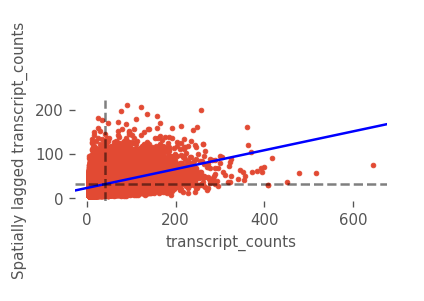

In [41]:
vp.plotting.moran_plot(adata, feature = 'transcript_counts', graph_name = 'knn_graph', figsize=(3,3))

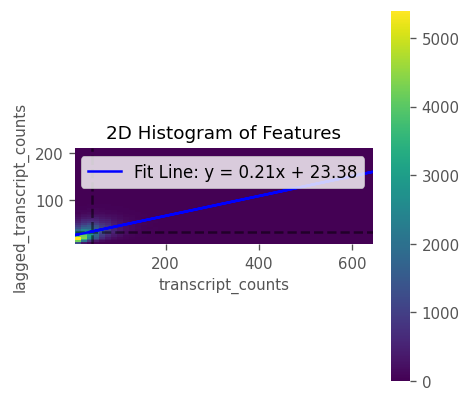

In [42]:
feature_name = 'transcript_counts'
graph_name = 'knn_graph'
vp.plotting.create_spatial_lag_2d_histogram(adata, feature_name, graph_name)

log normalize counts

In [43]:
if adata.X.dtype != 'float64':
    adata.X = adata.X.astype('float64')

adata.layers['counts'] = adata.X.copy()
vp.utils.log_norm_counts(adata, inplace=True)
adata.layers['logcounts'] = adata.X.copy()

compute global Moran's I

In [44]:
vp.spatial.moran(adata, feature=list(adata.var.index), dim='var', graph_name='knn_graph')
genes_moransI = adata.uns['spatial']['moran']['knn_graph'].loc[list(adata.var.index), 'I']
adata.var.loc[:, "moran"] = genes_moransI
adata.var

WOAHHH
1
2
3
4
5


feature_type  total_expression      mean  \
ABCC11                       Gene Expression               207  0.001566   
ACE2                         Gene Expression              2213  0.016739   
ACKR1                        Gene Expression              2690  0.020347   
ACTA2                        Gene Expression             34774  0.263035   
ACTG2                        Gene Expression             46585  0.352375   
...                                      ...               ...       ...   
UnassignedCodeword_0494  Unassigned Codeword                 2  0.000015   
UnassignedCodeword_0495  Unassigned Codeword                 1  0.000008   
UnassignedCodeword_0496  Unassigned Codeword                 2  0.000015   
UnassignedCodeword_0497  Unassigned Codeword                 8  0.000061   
UnassignedCodeword_0499  Unassigned Codeword                 3  0.000023   

                         variance     moran  
ABCC11                   0.001654  0.001590  
ACE2                     0.030604  0.254818  
ACKR1                    0.044214  0.184382  
ACTA2                    0.589875  0.232438  
ACTG2                    0.886679  0.213590  
...                           ...       ...  
UnassignedCodeword_0494  0.000015 -0.000015  
UnassignedCodeword_0495  0.000008 -0.000008  
UnassignedCodeword_0496  0.000015 -0.000014  
UnassignedCodeword_0497  0.000061 -0.000059  
UnassignedCodeword_0499  0.000023 -0.000021  

[505 rows x 5 columns]

In [45]:
adata.var['symbol'] = adata.var.index
adata.var.loc[:, ["symbol", "moran"]].sort_values(by='moran', ascending=False)

symbol     moran
AMY2A    AMY2A  0.908591
INS        INS  0.780752
GCG        GCG  0.757728
GATM      GATM  0.730470
GPRC5A  GPRC5A  0.706625
...        ...       ...
GYPB      GYPB -0.000497
CRHBP    CRHBP -0.000786
UPK3B    UPK3B -0.000989
ASCL1    ASCL1 -0.001090
TCF15    TCF15 -0.001253

[505 rows x 2 columns]

Plot histogram of global moran's I across genes

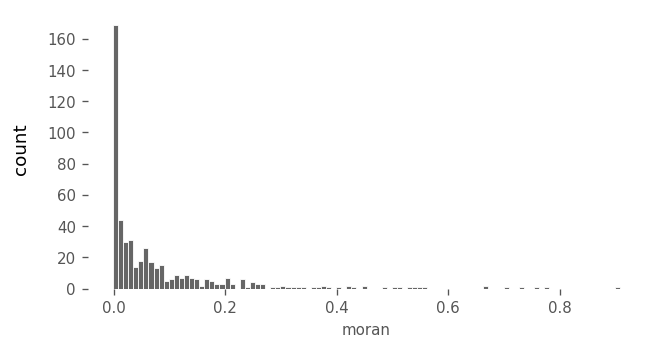

In [46]:
_ = vp.plt.plot_features_histogram(
    adata,
    "moran",
    bins=100,
    log=False,
    histtype="bar" ,
    show_symbol=True,
    figsize = (6,3)
)

Repeat for negative controls

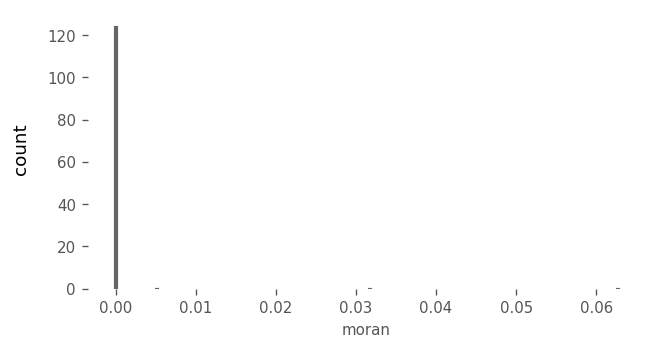

In [47]:
filtered_var_index = adata.var.index[adata.var.index.str.contains('Unassigned|NegControl')]
adata_negative_control = adata[:, filtered_var_index].copy()

_ = vp.plt.plot_features_histogram(
    adata_negative_control,
    "moran",
    bins=100,
    log=False,
    histtype="bar" ,
    show_symbol=True,
    figsize = (6,3)
)

Repeat for non-negative controls

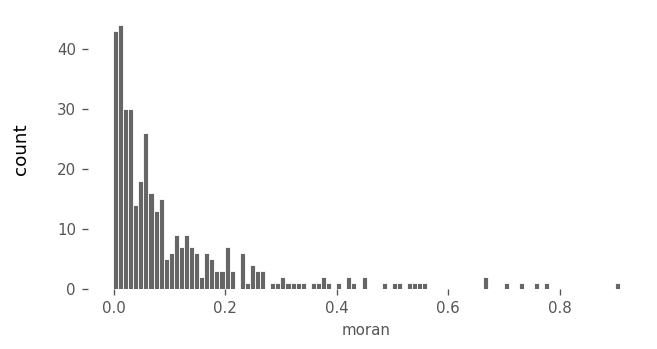

In [48]:
filtered_var_index = adata.var.index[~adata.var.index.str.contains('Unassigned|NegControl')]
adata_filtered = adata[:, filtered_var_index].copy()

_ = vp.plt.plot_features_histogram(
    adata_filtered,
    "moran",
    bins=100,
    log=False,
    histtype="bar" ,
    show_symbol=True,
    figsize = (6,3)
)

Print the genes with top Moran's I

In [49]:
top_moran = adata.var['moran'] \
                    .dropna() \
                    .sort_values(ascending=False) \
                    .head(9) \
                    .index.tolist()

top_moran

['AMY2A', 'INS', 'GCG', 'GATM', 'GPRC5A', 'SST', 'CFTR', 'DMBT1', 'GPX2']

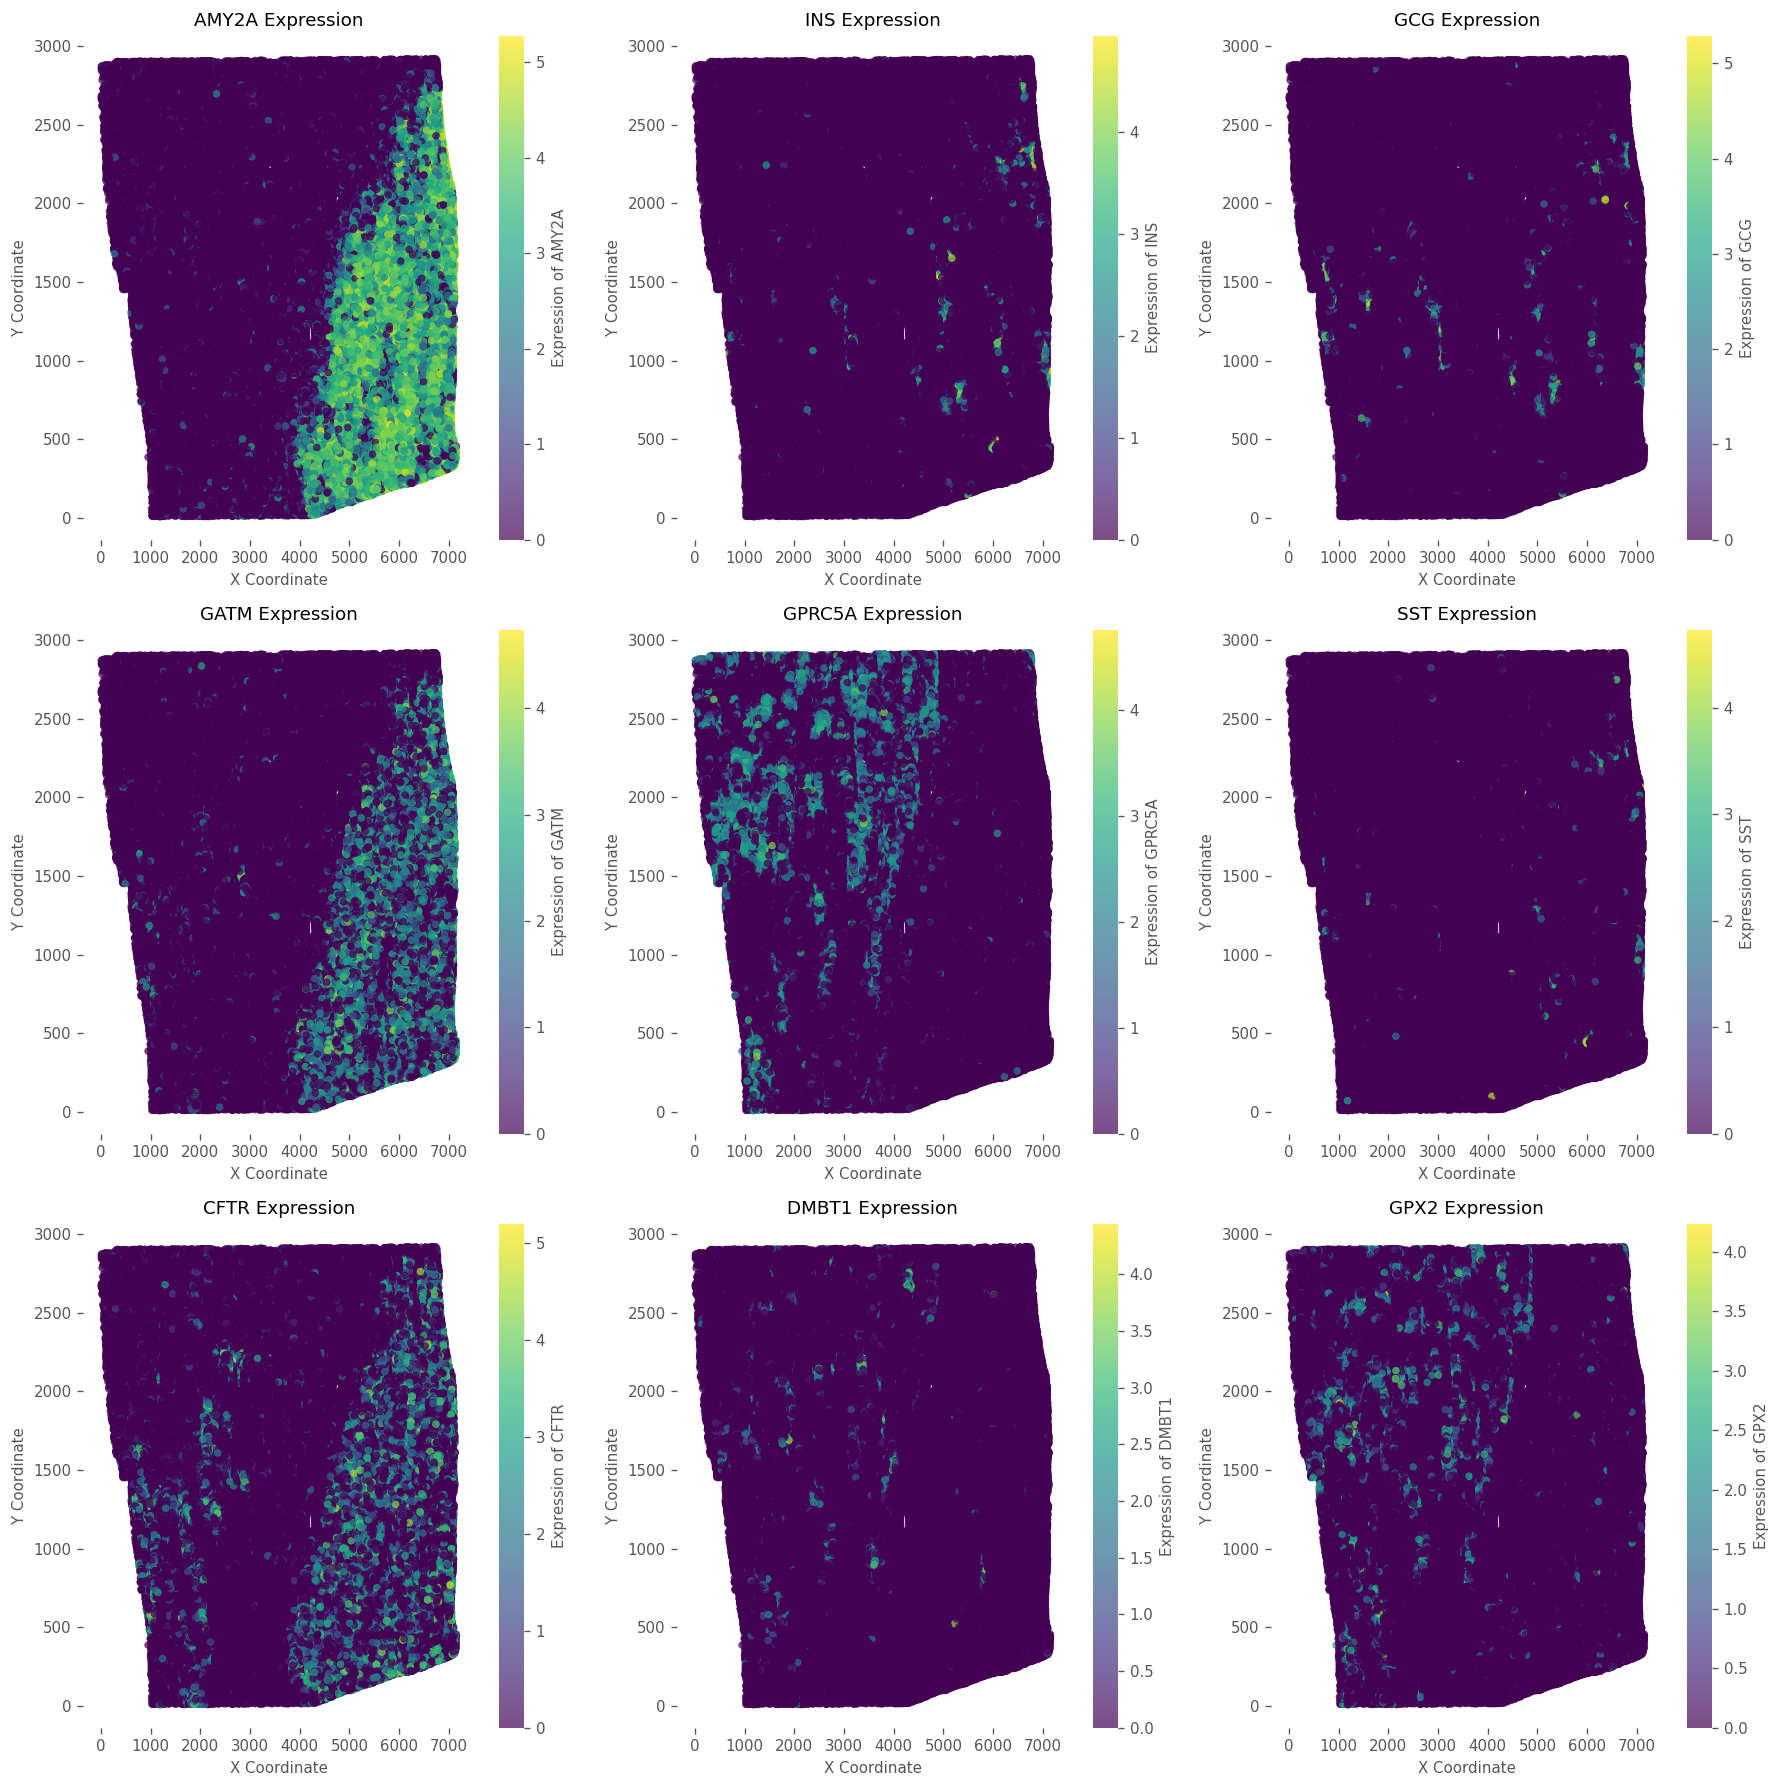

In [50]:
vp.plotting.plot_gene_expression_spatial_xenium(adata, top_moran)

In [51]:
%load_ext watermark
%watermark -v -m --iversions
# %watermark -v -m --iversions -p package1,package2,etc

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.18.1

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.3.13-linuxkit
Machine     : aarch64
Processor   : 
CPU cores   : 7
Architecture: 64bit

scipy     : 1.10.1
voyagerpy : 0.1.1
sys       : 3.9.18 (main, Oct 12 2023, 02:17:36) 
[GCC 12.2.0]
matplotlib: 3.6.3
numpy     : 1.23.5
geopandas : 0.13.2
pandas    : 2.2.2

